# [Hands-On] Naive Bayes & SVM을 활용한 판독문 분류

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요

의료 판독문 텍스트를 **Naive Bayes**와 **SVM** 두 가지 알고리즘으로 분류하고 성능을 비교합니다.

**데이터셋**: 1,275건의 의료 판독문 (흉부, 복부, 뇌, 심장 등)

**실습 내용**:
1. 텍스트 전처리 및 TF-IDF 벡터화
2. Multinomial Naive Bayes 분류기 학습
3. Support Vector Machine (SVM) 분류기 학습
4. 두 모델의 성능 비교 및 분석
5. 앙상블 기법으로 성능 개선

---

## 1. 데이터 다운로드 및 환경 설정

In [ ]:
# Colab 환경 체크 및 데이터 다운로드
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 데이터 파일이 없으면 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")

        # Dropbox 링크를 직접 다운로드 가능한 URL로 변경
        # dl=0을 dl=1로 변경
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"

        !wget -O medical_reports.tsv "{url}"

        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정 (오프라인 환경에서도 에러 없이 동작하도록 안전 가드 포함)
    print("한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

Google Colab 환경 감지
데이터 파일 다운로드 중...
--2025-11-13 14:21:30--  https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucddbbfafdec4c0f6c6871e3fc2b.dl.dropboxusercontent.com/cd/0/inline/C1EqbsMJsu-qJ_supd2wipj8hl8Dj6Hz-wQRfwvKtcKz5RXO_pcbqUfnwuHtX0_qStB82EwdlvZn4UqiV-T9xbyV1HtI28amC8Z1llf2dnNN-KsSLacIjSx8d5zyO2pWk7Y/file?dl=1# [following]
--2025-11-13 14:21:31--  https://ucddbbfafdec4c0f6c6871e3fc2b.dl.dropboxusercontent.com/cd/0/inline/C1EqbsMJsu-qJ_supd2wipj8hl8Dj6Hz-wQRfwvKtcKz5RXO_pcbqUfnwuHtX0_qStB82EwdlvZn4UqiV-T9xbyV1HtI28amC8Z1llf2dnNN-KsSLacIjSx8d5zyO2pWk7Y/file?dl=1
Resolving ucddbbfafdec4c0f6c6871e3fc2b.dl.dropboxusercontent.com (ucddbbfafdec4c0f6c6871e3fc2b.dl.dropboxusercontent

## 2. 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import time

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# 한글 폰트 설정
if IN_COLAB:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    # 로컬 환경에서는 시스템 폰트 사용
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("⚠ 한글 폰트가 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


## 3. 데이터 로드 및 전처리

In [ ]:
# 데이터 로드 (환경에 따라 경로 자동 선택)
if IN_COLAB:
    data_path = 'medical_reports.tsv'
else:
    data_path = '../../../data/medical_reports.tsv'

df = pd.read_csv(data_path, sep='\t')

print(f"데이터 크기: {len(df):,}건")
print(f"\n카테고리별 분포:")
print(df['category'].value_counts())

데이터 크기: 1,275건

카테고리별 분포:
category
정상        491
경과관찰      455
즉시치료필요    171
추가검사필요    158
Name: count, dtype: int64


In [ ]:
# 데이터 전처리
print("=" * 70)
print("데이터 전처리")
print("=" * 70)

# 필요한 컬럼만 선택
df_clean = df[['findings', 'impression', 'category']].dropna()

# 텍스트 결합
df_clean['text'] = df_clean['findings'] + ' ' + df_clean['impression']

print(f"\n전처리 후 데이터: {len(df_clean):,}건")

# Train/Test 분할
X = df_clean['text'].values
y = df_clean['category'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain 데이터: {len(X_train):,}건")
print(f"Test 데이터: {len(X_test):,}건")

데이터 전처리

전처리 후 데이터: 1,275건

Train 데이터: 1,020건
Test 데이터: 255건


---

## 4. 벡터화 전략 비교

**Naive Bayes와 SVM은 서로 다른 벡터화 방법에서 최적 성능을 보입니다**:

- **Naive Bayes**: CountVectorizer (단어 빈도) 또는 TF-IDF 모두 가능
  - 확률 기반 모델이므로 단순 빈도도 잘 작동
  - 빠른 학습 속도

- **SVM**: TF-IDF 권장
  - 거리 기반 모델이므로 정규화된 TF-IDF가 유리
  - 더 높은 성능, 하지만 느린 학습 속도

### 4.1 TF-IDF 벡터화

In [ ]:
print("=" * 70)
print("TF-IDF 벡터화")
print("=" * 70)

# TF-IDF Vectorizer 생성
tfidf_vectorizer = TfidfVectorizer(
    max_features=1500,      # 상위 1500개 특성
    ngram_range=(1, 2),     # 1-gram과 2-gram
    min_df=2,               # 최소 2개 문서에 등장
    sublinear_tf=True       # TF에 log 스케일 적용
)

# 벡터화
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF 벡터 shape:")
print(f"  Train: {X_train_tfidf.shape}")
print(f"  Test: {X_test_tfidf.shape}")

TF-IDF 벡터화

TF-IDF 벡터 shape:
  Train: (1020, 1500)
  Test: (255, 1500)


### 4.2 Count 벡터화 (Naive Bayes용 비교)

In [ ]:
print("=" * 70)
print("Count 벡터화")
print("=" * 70)

# Count Vectorizer 생성
count_vectorizer = CountVectorizer(
    max_features=1500,
    ngram_range=(1, 2),
    min_df=2
)

# 벡터화
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"\nCount 벡터 shape:")
print(f"  Train: {X_train_count.shape}")
print(f"  Test: {X_test_count.shape}")

Count 벡터화

Count 벡터 shape:
  Train: (1020, 1500)
  Test: (255, 1500)


---

## 5. Naive Bayes 분류기

**Naive Bayes Classifier**:
- 베이즈 정리 기반의 확률적 분류기
- 특성 간 독립성을 가정 ("Naive" 가정)
- 빠른 학습 및 예측 속도
- 텍스트 분류에 효과적

**Multinomial Naive Bayes**:
- 다항 분포를 가정
- 단어 빈도 데이터에 적합
- 텍스트 분류의 baseline 모델로 자주 사용

### 5.1 Naive Bayes with TF-IDF

In [ ]:
print("=" * 70)
print("Naive Bayes (TF-IDF)")
print("=" * 70)

# 모델 생성 및 학습
start_time = time.time()
nb_tfidf = MultinomialNB(alpha=0.1)  # alpha: Laplace smoothing
nb_tfidf.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

# 예측
y_train_pred_nb_tfidf = nb_tfidf.predict(X_train_tfidf)
y_test_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

# 성능 평가
train_acc_nb_tfidf = accuracy_score(y_train, y_train_pred_nb_tfidf)
test_acc_nb_tfidf = accuracy_score(y_test, y_test_pred_nb_tfidf)
train_f1_nb_tfidf = f1_score(y_train, y_train_pred_nb_tfidf, average='macro')
test_f1_nb_tfidf = f1_score(y_test, y_test_pred_nb_tfidf, average='macro')

print(f"\n학습 시간: {train_time:.4f}초")
print(f"\n[Train 성능]")
print(f"  Accuracy: {train_acc_nb_tfidf:.4f} ({train_acc_nb_tfidf*100:.2f}%)")
print(f"  F1-Score: {train_f1_nb_tfidf:.4f}")
print(f"\n[Test 성능]")
print(f"  Accuracy: {test_acc_nb_tfidf:.4f} ({test_acc_nb_tfidf*100:.2f}%)")
print(f"  F1-Score: {test_f1_nb_tfidf:.4f}")

Naive Bayes (TF-IDF)

학습 시간: 0.0148초

[Train 성능]
  Accuracy: 0.9843 (98.43%)
  F1-Score: 0.9743

[Test 성능]
  Accuracy: 0.9804 (98.04%)
  F1-Score: 0.9662


### 5.2 Naive Bayes with Count Vectorizer

In [ ]:
print("=" * 70)
print("Naive Bayes (Count)")
print("=" * 70)

# 모델 생성 및 학습
start_time = time.time()
nb_count = MultinomialNB(alpha=0.1)
nb_count.fit(X_train_count, y_train)
train_time = time.time() - start_time

# 예측
y_train_pred_nb_count = nb_count.predict(X_train_count)
y_test_pred_nb_count = nb_count.predict(X_test_count)

# 성능 평가
train_acc_nb_count = accuracy_score(y_train, y_train_pred_nb_count)
test_acc_nb_count = accuracy_score(y_test, y_test_pred_nb_count)
train_f1_nb_count = f1_score(y_train, y_train_pred_nb_count, average='macro')
test_f1_nb_count = f1_score(y_test, y_test_pred_nb_count, average='macro')

print(f"\n학습 시간: {train_time:.4f}초")
print(f"\n[Train 성능]")
print(f"  Accuracy: {train_acc_nb_count:.4f} ({train_acc_nb_count*100:.2f}%)")
print(f"  F1-Score: {train_f1_nb_count:.4f}")
print(f"\n[Test 성능]")
print(f"  Accuracy: {test_acc_nb_count:.4f} ({test_acc_nb_count*100:.2f}%)")
print(f"  F1-Score: {test_f1_nb_count:.4f}")

Naive Bayes (Count)

학습 시간: 0.0075초

[Train 성능]
  Accuracy: 0.9843 (98.43%)
  F1-Score: 0.9756

[Test 성능]
  Accuracy: 0.9843 (98.43%)
  F1-Score: 0.9718


### 5.3 Naive Bayes 클래스별 성능

Naive Bayes 상세 리포트 (TF-IDF)

분류 리포트:
              precision    recall  f1-score   support

        경과관찰       0.98      1.00      0.99        91
          정상       1.00      1.00      1.00        98
      즉시치료필요       0.97      0.94      0.96        34
      추가검사필요       0.94      0.91      0.92        32

    accuracy                           0.98       255
   macro avg       0.97      0.96      0.97       255
weighted avg       0.98      0.98      0.98       255



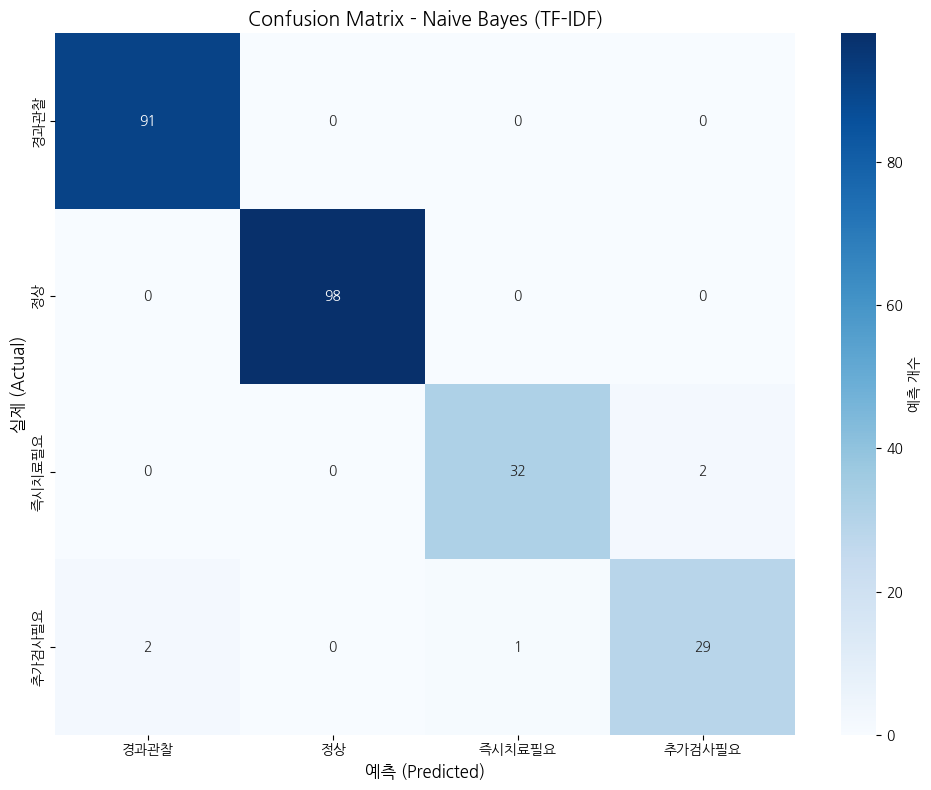

In [ ]:
print("=" * 70)
print("Naive Bayes 상세 리포트 (TF-IDF)")
print("=" * 70)

print("\n분류 리포트:")
print(classification_report(y_test, y_test_pred_nb_tfidf))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_test_pred_nb_tfidf,
                         labels=np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y),
            cbar_kws={'label': '예측 개수'})
plt.xlabel('예측 (Predicted)', fontsize=12)
plt.ylabel('실제 (Actual)', fontsize=12)
plt.title('Confusion Matrix - Naive Bayes (TF-IDF)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 6. Support Vector Machine (SVM) 분류기

**Support Vector Machine**:
- 데이터 포인트를 고차원 공간으로 매핑
- 최대 마진을 가진 초평면(hyperplane)을 찾음
- 높은 성능, 특히 텍스트 분류에 탁월
- 학습 시간이 Naive Bayes보다 오래 걸림

**LinearSVC vs SVC**:
- **LinearSVC**: 선형 커널만 사용, 빠름, 대용량 데이터에 적합
- **SVC**: 다양한 커널 사용 가능 (RBF, poly 등), 유연하지만 느림

### 6.1 Linear SVM

In [ ]:
print("=" * 70)
print("Linear SVM")
print("=" * 70)

# 모델 생성 및 학습
start_time = time.time()
svm_linear = LinearSVC(
    C=1.0,              # 정규화 파라미터
    max_iter=1000,      # 최대 반복 횟수
    random_state=42
)
svm_linear.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

# 예측
y_train_pred_svm = svm_linear.predict(X_train_tfidf)
y_test_pred_svm = svm_linear.predict(X_test_tfidf)

# 성능 평가
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='macro')
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='macro')

print(f"\n학습 시간: {train_time:.4f}초")
print(f"\n[Train 성능]")
print(f"  Accuracy: {train_acc_svm:.4f} ({train_acc_svm*100:.2f}%)")
print(f"  F1-Score: {train_f1_svm:.4f}")
print(f"\n[Test 성능]")
print(f"  Accuracy: {test_acc_svm:.4f} ({test_acc_svm*100:.2f}%)")
print(f"  F1-Score: {test_f1_svm:.4f}")

Linear SVM

학습 시간: 0.0816초

[Train 성능]
  Accuracy: 0.9990 (99.90%)
  F1-Score: 0.9987

[Test 성능]
  Accuracy: 0.9804 (98.04%)
  F1-Score: 0.9641


### 6.2 SVM with RBF Kernel (선택적)

**주의**: RBF 커널은 학습 시간이 매우 오래 걸립니다!
- 소규모 데이터에만 권장
- 샘플 수가 많으면 LinearSVC 사용 권장

In [ ]:
print("=" * 70)
print("SVM with RBF Kernel (샘플 데이터로 테스트)")
print("=" * 70)

# 샘플 데이터로만 테스트 (전체 데이터는 너무 오래 걸림)
sample_size = 200
X_train_sample = X_train_tfidf[:sample_size]
y_train_sample = y_train[:sample_size]

print(f"\n샘플 크기: {sample_size}건으로 테스트")
print("(전체 데이터는 시간이 오래 걸려 샘플만 사용)")

start_time = time.time()
svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42
)
svm_rbf.fit(X_train_sample, y_train_sample)
train_time = time.time() - start_time

# Test 데이터로 예측
y_test_pred_rbf = svm_rbf.predict(X_test_tfidf)
test_acc_rbf = accuracy_score(y_test, y_test_pred_rbf)
test_f1_rbf = f1_score(y_test, y_test_pred_rbf, average='macro')

print(f"\n학습 시간: {train_time:.4f}초 (샘플 {sample_size}건)")
print(f"\n[Test 성능]")
print(f"  Accuracy: {test_acc_rbf:.4f} ({test_acc_rbf*100:.2f}%)")
print(f"  F1-Score: {test_f1_rbf:.4f}")
print(f"\n💡 RBF 커널은 작은 데이터셋에서 더 나은 성능을 보일 수 있지만")
print(f"   대용량 데이터에서는 Linear SVM이 더 실용적입니다.")

SVM with RBF Kernel (샘플 데이터로 테스트)

샘플 크기: 200건으로 테스트
(전체 데이터는 시간이 오래 걸려 샘플만 사용)

학습 시간: 0.0988초 (샘플 200건)

[Test 성능]
  Accuracy: 0.9098 (90.98%)
  F1-Score: 0.8536

💡 RBF 커널은 작은 데이터셋에서 더 나은 성능을 보일 수 있지만
   대용량 데이터에서는 Linear SVM이 더 실용적입니다.


### 6.3 SVM 클래스별 성능

Linear SVM 상세 리포트

분류 리포트:
              precision    recall  f1-score   support

        경과관찰       0.99      1.00      0.99        91
          정상       1.00      1.00      1.00        98
      즉시치료필요       0.94      0.94      0.94        34
      추가검사필요       0.94      0.91      0.92        32

    accuracy                           0.98       255
   macro avg       0.97      0.96      0.96       255
weighted avg       0.98      0.98      0.98       255



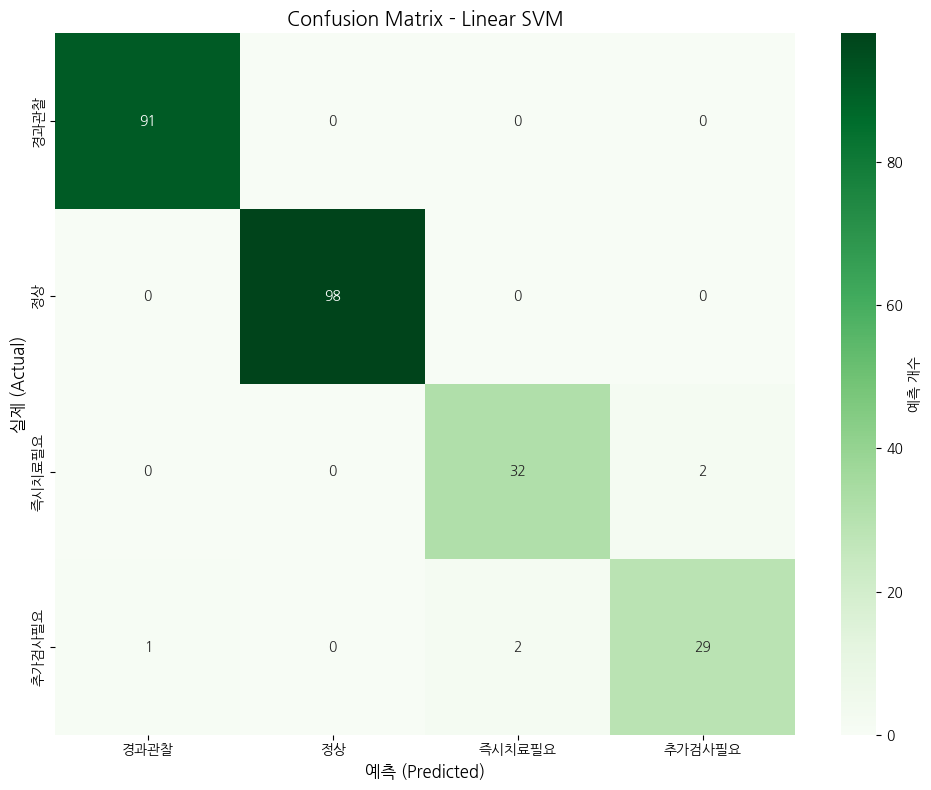

In [ ]:
print("=" * 70)
print("Linear SVM 상세 리포트")
print("=" * 70)

print("\n분류 리포트:")
print(classification_report(y_test, y_test_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm,
                          labels=np.unique(y))

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y), yticklabels=np.unique(y),
            cbar_kws={'label': '예측 개수'})
plt.xlabel('예측 (Predicted)', fontsize=12)
plt.ylabel('실제 (Actual)', fontsize=12)
plt.title('Confusion Matrix - Linear SVM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 7. 모델 비교 분석

학습한 3가지 모델의 성능을 종합적으로 비교합니다:
1. Naive Bayes (TF-IDF)
2. Naive Bayes (Count)
3. Linear SVM (TF-IDF)

### 7.1 성능 지표 비교

In [ ]:
print("=" * 70)
print("모델 성능 종합 비교")
print("=" * 70)

# 결과 정리
results = {
    'Model': [
        'Naive Bayes (TF-IDF)',
        'Naive Bayes (Count)',
        'Linear SVM'
    ],
    'Train Accuracy': [
        train_acc_nb_tfidf,
        train_acc_nb_count,
        train_acc_svm
    ],
    'Test Accuracy': [
        test_acc_nb_tfidf,
        test_acc_nb_count,
        test_acc_svm
    ],
    'Train F1': [
        train_f1_nb_tfidf,
        train_f1_nb_count,
        train_f1_svm
    ],
    'Test F1': [
        test_f1_nb_tfidf,
        test_f1_nb_count,
        test_f1_svm
    ]
}

results_df = pd.DataFrame(results)

print("\n성능 비교표:\n")
print(results_df.to_string(index=False))

# 최고 성능 모델
best_model_idx = results_df['Test Accuracy'].idxmax()
best_model = results_df.iloc[best_model_idx]

print(f"\n🏆 최고 성능 모델: {best_model['Model']}")
print(f"   Test Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"   Test F1-Score: {best_model['Test F1']:.4f}")

모델 성능 종합 비교

성능 비교표:

               Model  Train Accuracy  Test Accuracy  Train F1  Test F1
Naive Bayes (TF-IDF)        0.984314       0.980392  0.974267 0.966247
 Naive Bayes (Count)        0.984314       0.984314  0.975638 0.971815
          Linear SVM        0.999020       0.980392  0.998661 0.964087

🏆 최고 성능 모델: Naive Bayes (Count)
   Test Accuracy: 0.9843
   Test F1-Score: 0.9718


### 7.2 성능 시각화

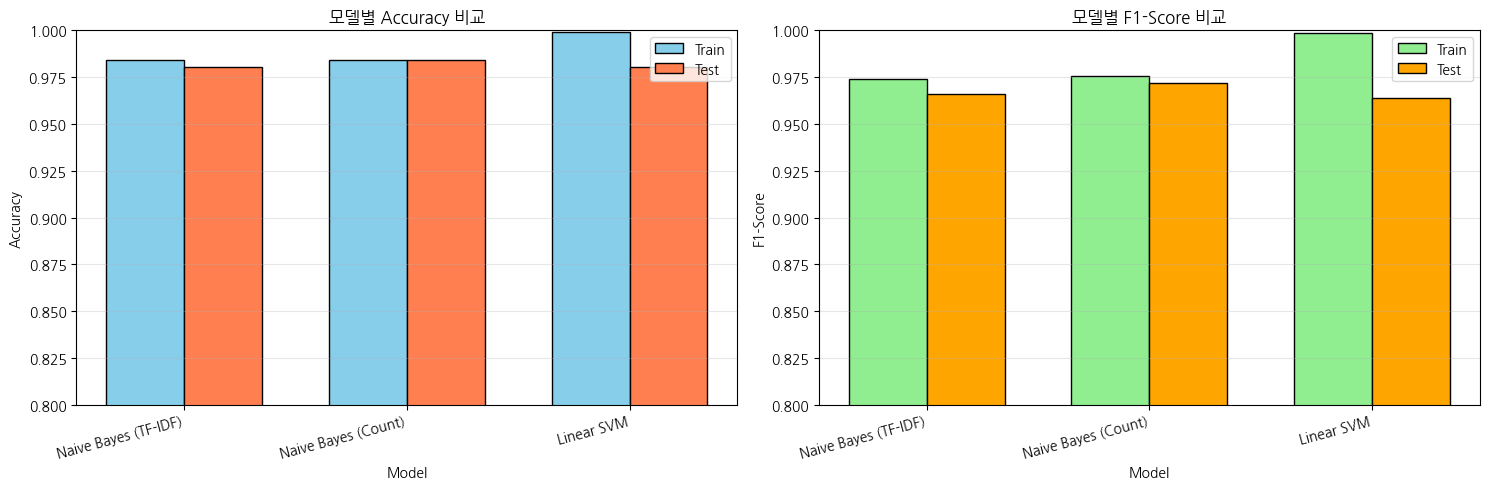

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy 비교
x_pos = np.arange(len(results_df))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['Train Accuracy'], width,
            label='Train', color='skyblue', edgecolor='black')
axes[0].bar(x_pos + width/2, results_df['Test Accuracy'], width,
            label='Test', color='coral', edgecolor='black')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('모델별 Accuracy 비교', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim([0.8, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# F1-Score 비교
axes[1].bar(x_pos - width/2, results_df['Train F1'], width,
            label='Train', color='lightgreen', edgecolor='black')
axes[1].bar(x_pos + width/2, results_df['Test F1'], width,
            label='Test', color='orange', edgecolor='black')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('모델별 F1-Score 비교', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 클래스별 F1-Score 비교

클래스별 F1-Score 비교

클래스별 F1-Score:

 Class  NB (TF-IDF)  NB (Count)  Linear SVM
  경과관찰     0.989130    0.994536    0.994536
    정상     1.000000    1.000000    1.000000
즉시치료필요     0.955224    0.955224    0.941176
추가검사필요     0.920635    0.937500    0.920635


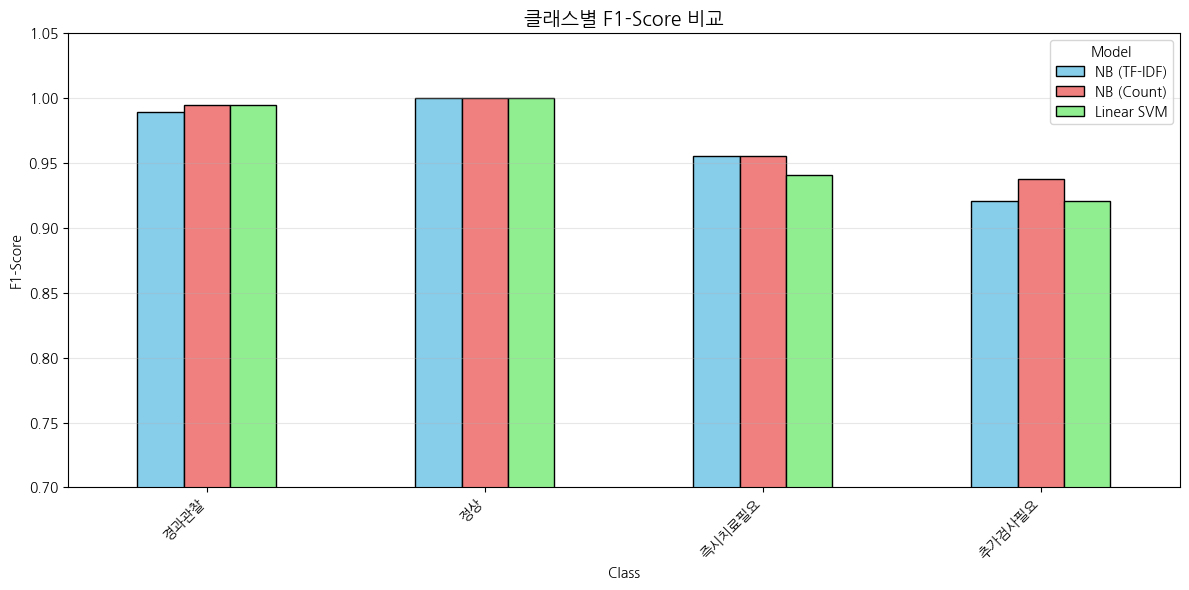

In [ ]:
print("=" * 70)
print("클래스별 F1-Score 비교")
print("=" * 70)

# 각 모델의 클래스별 F1-Score 추출
from sklearn.metrics import f1_score

classes = np.unique(y)

f1_nb_tfidf_per_class = f1_score(y_test, y_test_pred_nb_tfidf,
                                  average=None, labels=classes)
f1_nb_count_per_class = f1_score(y_test, y_test_pred_nb_count,
                                  average=None, labels=classes)
f1_svm_per_class = f1_score(y_test, y_test_pred_svm,
                            average=None, labels=classes)

# 데이터프레임으로 정리
f1_comparison = pd.DataFrame({
    'Class': classes,
    'NB (TF-IDF)': f1_nb_tfidf_per_class,
    'NB (Count)': f1_nb_count_per_class,
    'Linear SVM': f1_svm_per_class
})

print("\n클래스별 F1-Score:\n")
print(f1_comparison.to_string(index=False))

# 시각화
f1_comparison.set_index('Class').plot(kind='bar', figsize=(12, 6),
                                      color=['skyblue', 'lightcoral', 'lightgreen'],
                                      edgecolor='black')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('클래스별 F1-Score 비교', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.ylim([0.7, 1.05])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 8. 앙상블 (Voting) 기법

**앙상블 학습**:
- 여러 모델의 예측을 결합하여 더 나은 성능을 얻는 기법
- Voting: 여러 모델의 예측 결과를 투표로 결정

**Hard Voting**:
- 각 모델의 예측 클래스를 투표
- 과반수가 선택한 클래스로 최종 결정

In [ ]:
print("=" * 70)
print("앙상블 (Hard Voting)")
print("=" * 70)

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Fit on all unique classes from the original dataset to ensure all possible labels are covered
label_encoder.fit(np.unique(y))

# Encode predictions to numerical values
encoded_nb_tfidf = label_encoder.transform(y_test_pred_nb_tfidf)
encoded_nb_count = label_encoder.transform(y_test_pred_nb_count)
encoded_svm = label_encoder.transform(y_test_pred_svm)

# Each model's prediction is combined (now numerical)
predictions_encoded = np.array([
    encoded_nb_tfidf,
    encoded_nb_count,
    encoded_svm
])

# Hard Voting (다수결)
from scipy.stats import mode

# 각 샘플에 대해 가장 많이 예측된 클래스 선택
voting_result_encoded = mode(predictions_encoded, axis=0, keepdims=False)
y_test_pred_voting_encoded = voting_result_encoded.mode

# Inverse transform the voting result back to original labels
y_test_pred_voting = label_encoder.inverse_transform(y_test_pred_voting_encoded)

# 성능 평가
test_acc_voting = accuracy_score(y_test, y_test_pred_voting)
test_f1_voting = f1_score(y_test, y_test_pred_voting, average='macro')

print(f"\n[앙상블 성능]")
print(f"  Test Accuracy: {test_acc_voting:.4f} ({test_acc_voting*100:.2f}%)")
print(f"  Test F1-Score: {test_f1_voting:.4f}")

# 개별 모델과 비교
print(f"\n개별 모델 vs 앙상블:")
print(f"  NB (TF-IDF):   {test_acc_nb_tfidf:.4f}")
print(f"  NB (Count):    {test_acc_nb_count:.4f}")
print(f"  Linear SVM:    {test_acc_svm:.4f}")
print(f"  Ensemble:      {test_acc_voting:.4f}")

if test_acc_voting > max(test_acc_nb_tfidf, test_acc_nb_count, test_acc_svm):
    print("\n✅ 앙상블이 모든 개별 모델보다 높은 성능!")
else:
    print("\n⚠️ 앙상블이 최고 성능 모델보다 낮거나 같음")

앙상블 (Hard Voting)

[앙상블 성능]
  Test Accuracy: 0.9843 (98.43%)
  Test F1-Score: 0.9718

개별 모델 vs 앙상블:
  NB (TF-IDF):   0.9804
  NB (Count):    0.9843
  Linear SVM:    0.9804
  Ensemble:      0.9843

⚠️ 앙상블이 최고 성능 모델보다 낮거나 같음


---

## 9. 오분류 사례 비교 분석

각 모델이 어떤 케이스를 잘못 예측하는지 비교합니다.

In [ ]:
print("=" * 70)
print("오분류 사례 비교")
print("=" * 70)

# 각 모델의 오분류 여부
nb_tfidf_wrong = (y_test != y_test_pred_nb_tfidf)
nb_count_wrong = (y_test != y_test_pred_nb_count)
svm_wrong = (y_test != y_test_pred_svm)

print(f"\n오분류 개수:")
print(f"  NB (TF-IDF): {nb_tfidf_wrong.sum()}건")
print(f"  NB (Count):  {nb_count_wrong.sum()}건")
print(f"  Linear SVM:  {svm_wrong.sum()}건")

# 모든 모델이 틀린 케이스
all_wrong = nb_tfidf_wrong & nb_count_wrong & svm_wrong
print(f"\n모든 모델이 틀린 케이스: {all_wrong.sum()}건")

# 하나의 모델만 맞춘 케이스
only_nb_tfidf_correct = (~nb_tfidf_wrong) & nb_count_wrong & svm_wrong
only_nb_count_correct = nb_tfidf_wrong & (~nb_count_wrong) & svm_wrong
only_svm_correct = nb_tfidf_wrong & nb_count_wrong & (~svm_wrong)

print(f"\n하나의 모델만 맞춘 케이스:")
print(f"  오직 NB (TF-IDF)만: {only_nb_tfidf_correct.sum()}건")
print(f"  오직 NB (Count)만:  {only_nb_count_correct.sum()}건")
print(f"  오직 Linear SVM만:  {only_svm_correct.sum()}건")

오분류 사례 비교

오분류 개수:
  NB (TF-IDF): 5건
  NB (Count):  4건
  Linear SVM:  5건

모든 모델이 틀린 케이스: 4건

하나의 모델만 맞춘 케이스:
  오직 NB (TF-IDF)만: 0건
  오직 NB (Count)만:  0건
  오직 Linear SVM만:  0건


In [ ]:
# 모든 모델이 틀린 어려운 케이스 출력
if all_wrong.sum() > 0:
    print("\n모든 모델이 틀린 어려운 케이스 (상위 3개):\n")
    all_wrong_idx = np.where(all_wrong)[0][:3]

    for i, idx in enumerate(all_wrong_idx):
        print(f"[어려운 케이스 {i+1}]")
        print(f"  텍스트: {X_test[idx][:100]}...")
        print(f"  실제:     {y_test[idx]}")
        print(f"  NB(TF):   {y_test_pred_nb_tfidf[idx]}")
        print(f"  NB(Count):{y_test_pred_nb_count[idx]}")
        print(f"  SVM:      {y_test_pred_svm[idx]}")
        print()


모든 모델이 틀린 어려운 케이스 (상위 3개):

[어려운 케이스 1]
  텍스트: 간 실질은 전반적으로 에코가 현저히 증가되어 심한 지방간 소견입니다. 비장은 약간 비대되어 있습니다(13cm). 심한 지방간 및 경미한 비장비대. 원인 감별 위해 추가 검사 권장합...
  실제:     추가검사필요
  NB(TF):   경과관찰
  NB(Count):경과관찰
  SVM:      경과관찰

[어려운 케이스 2]
  텍스트: L3-4 추간판이 후외측으로 탈출되어 있습니다. 신경근을 심하게 압박하고 있습니다. L3-4 추간판 탈출증. 정형외과 진료 및 치료가 필요합니다....
  실제:     즉시치료필요
  NB(TF):   추가검사필요
  NB(Count):추가검사필요
  SVM:      추가검사필요

[어려운 케이스 3]
  텍스트: L3-4, L4-5 레벨에서 척추관 협착증이 관찰됩니다. 다분절 협착 소견입니다. 다분절 척추관 협착증. 정형외과 진료 및 치료가 필요합니다....
  실제:     즉시치료필요
  NB(TF):   추가검사필요
  NB(Count):추가검사필요
  SVM:      추가검사필요



---

## 10. 실전 예측 테스트

새로운 판독문 샘플로 각 모델을 비교 테스트합니다.

In [ ]:
print("=" * 70)
print("실전 예측 테스트")
print("=" * 70)

# 새로운 판독문 샘플
new_samples = [
    "양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다.",
    "우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다.",
    "좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다.",
    "우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다.",
    "간 우엽에 약 2.5cm 크기의 종괴가 관찰됩니다. 간세포암 의심. 즉시 진료가 필요합니다."
]

# 벡터화
new_samples_tfidf = tfidf_vectorizer.transform(new_samples)
new_samples_count = count_vectorizer.transform(new_samples)

# 각 모델로 예측
pred_nb_tfidf = nb_tfidf.predict(new_samples_tfidf)
pred_nb_count = nb_count.predict(new_samples_count)
pred_svm = svm_linear.predict(new_samples_tfidf)

# 결과 출력
print("\n새로운 판독문 예측 결과:\n")
for i, sample in enumerate(new_samples):
    print(f"[샘플 {i+1}]")
    print(f"  판독문: {sample[:70]}...")
    print(f"  예측:")
    print(f"    NB (TF-IDF): {pred_nb_tfidf[i]}")
    print(f"    NB (Count):  {pred_nb_count[i]}")
    print(f"    Linear SVM:  {pred_svm[i]}")

    # 합의 여부 확인
    if pred_nb_tfidf[i] == pred_nb_count[i] == pred_svm[i]:
        print(f"    → 모든 모델 일치 ✓")
    else:
        print(f"    → 모델 간 예측 불일치 ⚠️")
    print()

실전 예측 테스트

새로운 판독문 예측 결과:

[샘플 1]
  판독문: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다....
  예측:
    NB (TF-IDF): 정상
    NB (Count):  정상
    Linear SVM:  정상
    → 모든 모델 일치 ✓

[샘플 2]
  판독문: 우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다....
  예측:
    NB (TF-IDF): 경과관찰
    NB (Count):  경과관찰
    Linear SVM:  경과관찰
    → 모든 모델 일치 ✓

[샘플 3]
  판독문: 좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다....
  예측:
    NB (TF-IDF): 즉시치료필요
    NB (Count):  즉시치료필요
    Linear SVM:  즉시치료필요
    → 모든 모델 일치 ✓

[샘플 4]
  판독문: 우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다....
  예측:
    NB (TF-IDF): 경과관찰
    NB (Count):  경과관찰
    Linear SVM:  경과관찰
    → 모든 모델 일치 ✓

[샘플 5]
  판독문: 간 우엽에 약 2.5cm 크기의 종괴가 관찰됩니다. 간세포암 의심. 즉시 진료가 필요합니다....
  예측:
    NB (TF-IDF): 즉시치료필요
    NB (Count):  즉시치료필요
    Linear SVM:  즉시치료필요
    → 모든 모델 일치 ✓



---

## 8. 모델 특성 분석

각 모델이 중요하게 생각하는 특성(단어)을 확인합니다.

### 8.1 Naive Bayes 특성 중요도

In [ ]:
print("=" * 70)
print("Naive Bayes 클래스별 중요 단어")
print("=" * 70)

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
classes = nb_tfidf.classes_

print("\n각 카테고리별 중요 단어 TOP 10:\n")
for i, category in enumerate(classes):
    # log probability를 사용하여 중요도 계산
    log_prob = nb_tfidf.feature_log_prob_[i]
    top_indices = np.argsort(log_prob)[-10:][::-1]

    print(f"[{category}]")
    for rank, idx in enumerate(top_indices, 1):
        word = feature_names[idx]
        prob = np.exp(log_prob[idx])
        print(f"  {rank:2d}. {word:20s} (확률: {prob:.6f})")
    print()

Naive Bayes 클래스별 중요 단어

각 카테고리별 중요 단어 TOP 10:

[경과관찰]
   1. 권장합니다                (확률: 0.013880)
   2. 크기의                  (확률: 0.010062)
   3. 관찰됩니다                (확률: 0.009846)
   4. 지방간                  (확률: 0.009161)
   5. 양성                   (확률: 0.009154)
   6. 추적관찰                 (확률: 0.007464)
   7. 낭종이                  (확률: 0.007118)
   8. 낭종이 관찰됩니다            (확률: 0.007118)
   9. 정상입니다                (확률: 0.007064)
  10. 추적관찰 권장합니다           (확률: 0.007040)

[정상]
   1. 정상                   (확률: 0.026325)
   2. 소견입니다                (확률: 0.020571)
   3. 양측                   (확률: 0.017818)
   4. 흉부                   (확률: 0.014645)
   5. 정상 흉부                (확률: 0.014439)
   6. 소견 없습니다              (확률: 0.014062)
   7. 없습니다                 (확률: 0.013927)
   8. 폐야는                  (확률: 0.013631)
   9. 양측 폐야는               (확률: 0.013631)
  10. 없습니다 정상              (확률: 0.013532)

[즉시치료필요]
   1. 필요합니다                (확률: 0.012942)
   2. 급성                   (확률: 0.009861)
   3. 

### 8.2 SVM 특성 중요도

In [ ]:
print("=" * 70)
print("Linear SVM 클래스별 중요 특성")
print("=" * 70)

# SVM의 계수(가중치) 사용
classes_svm = svm_linear.classes_

print("\n각 카테고리별 중요 단어 TOP 10:\n")
for i, category in enumerate(classes_svm):
    coef = svm_linear.coef_[i]
    top_indices = np.argsort(coef)[-10:][::-1]

    print(f"[{category}]")
    for rank, idx in enumerate(top_indices, 1):
        word = feature_names[idx]
        weight = coef[idx]
        print(f"  {rank:2d}. {word:20s} (가중치: {weight:7.3f})")
    print()

Linear SVM 클래스별 중요 특성

각 카테고리별 중요 단어 TOP 10:

[경과관찰]
   1. 권장합니다                (가중치:   1.611)
   2. 경미한                  (가중치:   1.036)
   3. 추적관찰 권장합니다           (가중치:   0.993)
   4. 추적관찰                 (가중치:   0.941)
   5. 증상 발생                (가중치:   0.898)
   6. 발생 외과                (가중치:   0.898)
   7. 발생                   (가중치:   0.898)
   8. 정기적인                 (가중치:   0.843)
   9. 필요합니다 폐문             (가중치:   0.831)
  10. 폐문 림프절               (가중치:   0.831)

[정상]
   1. 정상                   (가중치:   1.801)
   2. 소견입니다                (가중치:   1.199)
   3. 없습니다 정상              (가중치:   0.771)
   4. 초음파 소견입니다            (가중치:   0.745)
   5. 심장                   (가중치:   0.609)
   6. mri                  (가중치:   0.598)
   7. mri 소견입니다            (가중치:   0.598)
   8. 정상 심장                (가중치:   0.569)
   9. 초음파                  (가중치:   0.556)
  10. 정상입니다                (가중치:   0.552)

[즉시치료필요]
   1. 심한                   (가중치:   1.091)
   2. 급성                   (가중치:   1.034)
   3. 치

---

## Summary

### Naive Bayes vs SVM 비교

| 특징 | Naive Bayes | SVM |
|------|-------------|-----|
| **학습 속도** | 매우 빠름 ⚡ | 느림 🐢 |
| **예측 속도** | 매우 빠름 ⚡ | 빠름 ⚡ |
| **성능** | 양호 👍 | 우수 🌟 |
| **해석성** | 높음 📖 | 중간 📝 |
| **메모리** | 적음 💾 | 중간 💾💾 |
| **적합한 상황** | 빠른 프로토타입, baseline | 높은 성능 필요, 프로덕션 |

### 학습한 주요 내용

1. **벡터화 전략**
   - TF-IDF: SVM에 적합, 특성 정규화
   - Count: Naive Bayes에도 사용 가능, 단순 빈도

2. **Naive Bayes**
   - 확률 기반 분류
   - alpha (smoothing) 파라미터로 조정
   - 빠르고 효율적

3. **SVM**
   - 최대 마진 분류
   - C (정규화) 파라미터로 조정
   - Linear vs RBF 커널 선택

4. **앙상블**
   - Voting으로 여러 모델 결합
   - 성능 향상 가능

